In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import os
import cv2
from PIL import Image as PILImage
import keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

2025-11-16 19:00:34.542491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763319634.787172      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763319634.863366      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNEL = 3
BATCH_SIZE = 8
EPOCHS = 150
SEED = 13
smooth = 1.0

In [3]:
image_directory = r'/kaggle/input/cancersegment/Segmentation/images'
mask_directory = r'/kaggle/input/cancersegment/Segmentation/mask'

In [4]:
images = sorted(os.listdir(image_directory))
masks = sorted(os.listdir(mask_directory))

In [5]:
# Print image and corresponding mask names to check alignment
for i, image_name in enumerate(images[:5]):  # Checking first 5 examples
    mask_name = masks[i]
    print(f"Image: {image_name} -> Mask: {mask_name}")

Image: ALWI_000.png -> Mask: ALWI_000.png
Image: ALWI_001.png -> Mask: ALWI_001.png
Image: ALWI_002.png -> Mask: ALWI_002.png
Image: ALWI_003.png -> Mask: ALWI_003.png
Image: ALWI_004.png -> Mask: ALWI_004.png


In [6]:
image_basenames = [os.path.splitext(image)[0] for image in images]
mask_basenames = [os.path.splitext(mask)[0] for mask in masks]

# Check for missing masks
missing_masks = [image for image in image_basenames if image not in mask_basenames]

# Check for extra masks
extra_masks = [mask for mask in mask_basenames if mask not in image_basenames]

# Output results
print(f"Total images: {len(images)}")
print(f"Total masks: {len(masks)}")
print(f"Images missing masks: {len(missing_masks)}")
for missing in missing_masks:
    print(f"Missing mask for image: {missing}")

if extra_masks:
    print(f"\nExtra masks found ({len(extra_masks)}):")
    for extra in extra_masks:
        print(f"Extra mask without an image: {extra}")

Total images: 1688
Total masks: 2780
Images missing masks: 27
Missing mask for image: CHVI_009 (1)
Missing mask for image: CHVI_010 (1)
Missing mask for image: CHVI_011 (1)
Missing mask for image: CODE_004 (1)
Missing mask for image: benign (318)(1)
Missing mask for image: benign (328)(1)
Missing mask for image: benign (329)(1)
Missing mask for image: benign (33)(1)
Missing mask for image: benign (330)(1)
Missing mask for image: benign (331)(1)
Missing mask for image: benign (332)(1)
Missing mask for image: benign (333)(1)
Missing mask for image: benign (334)(1)
Missing mask for image: case045
Missing mask for image: case061
Missing mask for image: case110(1)
Missing mask for image: case111(1)
Missing mask for image: case112(1)
Missing mask for image: case113(1)
Missing mask for image: case114(1)
Missing mask for image: case117(1)
Missing mask for image: case118(1)
Missing mask for image: case120(1)
Missing mask for image: case121(1)
Missing mask for image: case122(1)
Missing mask for 

In [7]:
# Filter out images without matching masks
valid_images = [image for image in images if os.path.splitext(image)[0] in mask_basenames]

# Filter out masks without matching images (optional, if needed)
valid_masks = [mask for mask in masks if os.path.splitext(mask)[0] in image_basenames]

# Output results
print(f"Total valid images for training: {len(valid_images)}")
print(f"Total valid masks for training: {len(valid_masks)}")

# # For confirmation (optional)
# for image, mask in zip(valid_images, valid_masks):
#     print(f"Image: {image} | Mask: {mask}")

Total valid images for training: 1661
Total valid masks for training: 1661


In [8]:
from skimage.transform import resize
import os
import numpy as np
from PIL import Image as PILImage
import cv2
from IPython.display import Image, display  # Import for displaying images in Jupyter

# Define the size to which all images and masks will be resized
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNEL = 3  # For RGB images

# Initialize lists to store the images and masks
image_dataset = []
mask_dataset = []

# Ensure images and masks are sorted
images = sorted(os.listdir(image_directory))
masks = sorted(os.listdir(mask_directory))

# Create a mapping of image filenames to mask filenames
image_mask_map = {}
for image_name in images:
    if image_name.endswith('.jpg') or image_name.endswith('.png') or image_name.endswith('.tif'):
        base_name = os.path.splitext(image_name)[0]
        corresponding_mask = f"{base_name}.png"  # Assuming masks are in .png format
        image_mask_map[image_name] = corresponding_mask

# Load and process the images and masks
for image_name, mask_name in image_mask_map.items():
    if mask_name in masks:
        # Read and process image
        image_path = os.path.join(image_directory, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize using skimage
        image = image.astype(np.uint8)  # Ensure the dtype is uint8
        image_dataset.append(image)

        # Display the image using IPython's Image
        #display(PILImage.fromarray(image))  # For visualization in Jupyter

        # Read and process mask
        mask_path = os.path.join(mask_directory, mask_name)
        mask = cv2.imread(mask_path, 0)  # Read in grayscale
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize using skimage
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension (to get shape (H, W, 1))
        mask = mask.astype(bool)  # Use built-in Python bool type
        mask_dataset.append(mask)



# Convert lists to NumPy arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Normalize the images to the range [0, 1]
image_dataset = image_dataset / 255.0

# Ensure images and masks match in length
assert len(image_dataset) == len(mask_dataset), "Number of images and masks don't match!"

# Print a few to check they are paired correctly
for i in range(5):
    print(f"Image {i}: {images[i]} -> Mask {i}: {list(image_mask_map.values())[i]}")

print(f"Image dataset shape: {image_dataset.shape}")
print(f"Mask dataset shape: {mask_dataset.shape}")

Image 0: ALWI_000.png -> Mask 0: ALWI_000.png
Image 1: ALWI_001.png -> Mask 1: ALWI_001.png
Image 2: ALWI_002.png -> Mask 2: ALWI_002.png
Image 3: ALWI_003.png -> Mask 3: ALWI_003.png
Image 4: ALWI_004.png -> Mask 4: ALWI_004.png
Image dataset shape: (1661, 128, 128, 3)
Mask dataset shape: (1661, 128, 128, 1)


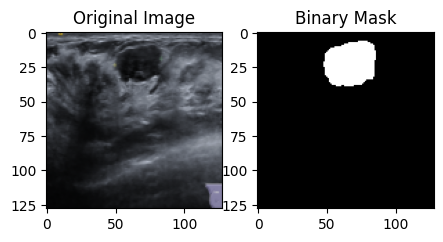

In [9]:
from matplotlib import pyplot as plt
# Visualize the first image and its corresponding binary mask
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_dataset[0])

plt.subplot(1, 2, 2)
plt.title('Binary Mask')
plt.imshow(mask_dataset[0], cmap='gray')

plt.show()

In [10]:
x_train, x_val, y_train, y_val = train_test_split(
    image_dataset, mask_dataset, test_size=0.45, random_state=SEED, shuffle=True
)
# Check shapes
print(f"Training images shape: {x_train.shape}")  # Should be (num_samples, 128, 128, 3)
print(f"Training masks shape: {y_train.shape}")   # Should be (num_samples, 128, 128, 1)
print(f"Validation images shape: {x_val.shape}")  # Should be (num_samples, 128, 128, 3)
print(f"Validation masks shape: {y_val.shape}")   # Should be (num_samples, 128, 128, 1)

Training images shape: (913, 128, 128, 3)
Training masks shape: (913, 128, 128, 1)
Validation images shape: (748, 128, 128, 3)
Validation masks shape: (748, 128, 128, 1)


In [11]:
# Training data augmentation
data_gen_args = dict(rotation_range=90.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.3,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

# Apply augmentation only for training data
X_datagen = ImageDataGenerator(**data_gen_args)
Y_datagen = ImageDataGenerator(**data_gen_args)

# No augmentation for validation data
X_datagen_val = ImageDataGenerator()  # Default, no augmentation
Y_datagen_val = ImageDataGenerator()  # Default, no augmentation

# Fitting generators for training data
X_datagen.fit(x_train, augment=True, seed=13)
Y_datagen.fit(y_train, augment=True, seed=13)

# Fitting generators for validation data (no augmentation)
X_datagen_val.fit(x_val, augment=False, seed=13)
Y_datagen_val.fit(y_val, augment=False, seed=13)

# Creating the data generators
X_train_augmented = X_datagen.flow(x_train, batch_size=8, shuffle=True, seed=13)
Y_train_augmented = Y_datagen.flow(y_train, batch_size=8, shuffle=True, seed=13)

# Validation data without augmentation
X_train_augmented_val = X_datagen_val.flow(x_val, batch_size=8, shuffle=False, seed=13)
Y_train_augmented_val = Y_datagen_val.flow(y_val, batch_size=8, shuffle=False, seed=13)

# Zip the augmented generators for training and validation
train_generator = zip(X_train_augmented, Y_train_augmented)
val_generator = zip(X_train_augmented_val, Y_train_augmented_val)

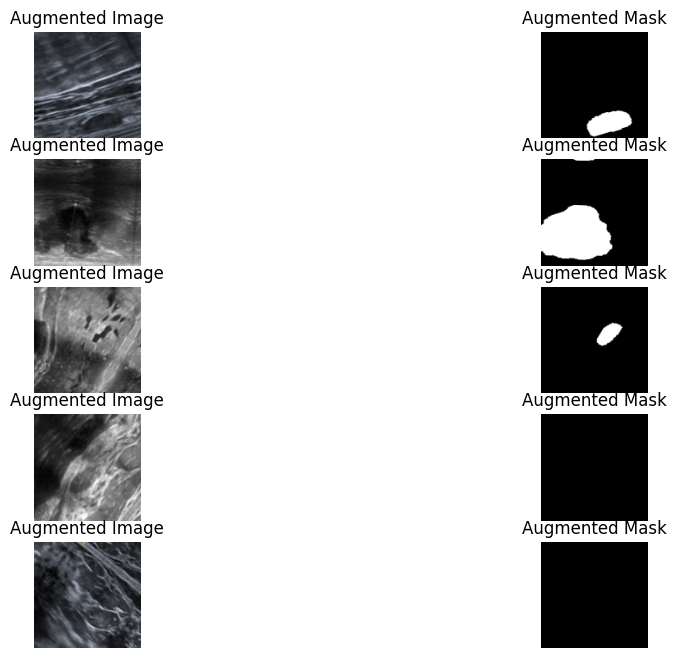

In [12]:
import matplotlib.pyplot as plt

def visualize_augmentation(generator, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        batch = next(generator)
        images = batch[0]
        masks = batch[1]

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(images[0])  # Display the first image of the batch
        plt.title('Augmented Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(masks[0].squeeze(), cmap='gray')  # Display the first mask of the batch
        plt.title('Augmented Mask')
        plt.axis('off')

    plt.show()

# Visualize augmented training images and masks
visualize_augmentation(train_generator, num_samples=5)

In [13]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy

# Dice loss function for multiclass segmentation
def dice_loss_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # One-hot encode y_pred if it's not already
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((numerator + smooth) / (denominator + smooth), axis=0)
    return 1 - dice

# Combined loss: categorical cross-entropy + dice loss
def combined_multiclass_loss(y_true, y_pred):
    categorical_loss = CategoricalCrossentropy(from_logits=False)
    return categorical_loss(y_true, y_pred) + dice_loss_multiclass(y_true, y_pred)

# IOU metric for multiclass segmentation
def iou_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)

    # Convert y_pred to one-hot encoding if necessary
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Dice coefficient metric for multiclass segmentation
def dice_coef_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)

    # Convert y_pred to one-hot encoding if necessary
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((numerator + smooth) / (denominator + smooth), axis=0)
    return dice

In [14]:
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from keras.regularizers import l2


SIZE=128

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def residual_block(x, filters, kernel_size=3, stride=1, regularizer=None, dropout_rate=0.0, activation='relu'):
    # First convolution
    conv = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                         kernel_regularizer=regularizer)(x)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation(activation)(conv)
    
    # Second convolution
    conv = layers.Conv2D(filters, kernel_size, strides=1, padding='same',
                         kernel_regularizer=regularizer)(conv)
    conv = layers.BatchNormalization()(conv)

    # Skip connection
    shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                             kernel_regularizer=regularizer)(x)
    shortcut = layers.BatchNormalization()(shortcut)

    # Combine and activate
    output = layers.Add()([conv, shortcut])
    output = layers.Activation(activation)(output)
    
    if dropout_rate > 0:
        output = layers.Dropout(dropout_rate)(output)

    return output

def StateOfArtResUNet(input_shape, num_classes, reg_value=1e-4, dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = residual_block(inputs, 64, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = residual_block(pool1, 128, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = residual_block(pool2, 256, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = residual_block(pool3, 512, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)

    # Bridge
    bridge = residual_block(pool4, 1024, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)

    # Decoder
    upconv4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat4 = layers.Concatenate()([upconv4, conv4])
    conv5 = residual_block(concat4, 512, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)

    upconv3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat3 = layers.Concatenate()([upconv3, conv3])
    conv6 = residual_block(concat3, 256, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)

    upconv2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat2 = layers.Concatenate()([upconv2, conv2])
    conv7 = residual_block(concat2, 128, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)

    upconv1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat1 = layers.Concatenate()([upconv1, conv1])
    conv8 = residual_block(concat1, 64, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)

    # Output Layer
    activation = 'softmax' if num_classes > 1 else 'sigmoid'
    outputs = layers.Conv2D(num_classes, (1, 1), activation=activation)(conv8)

    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
input_shape = (128, 128, 3)
num_classes = 4  # Example for multi-class segmentation
reg_value = 1e-4  # Reduced regularization to prevent underfitting
dropout_rate = 0.2  # Balanced dropout rate

model = StateOfArtResUNet(input_shape, num_classes, reg_value, dropout_rate)

# Print the summary of the model
model.summary()

I0000 00:00:1763319796.553601      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763319796.554437      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      8,320 │ max_pooling2d[0]

 Total params: 32,463,044 (123.84 MB)

 Trainable params: 32,445,380 (123.77 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [16]:
def combined_generator(image_gen, mask_gen):
    while True:
        X = image_gen.__next__()
        Y = mask_gen.__next__()
        if X.shape[0] == Y.shape[0]:

            Y = tf.one_hot(tf.cast(Y, tf.int32), depth=4)
            Y = tf.squeeze(Y, axis=3)
            yield X, Y

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(X_train_augmented, Y_train_augmented),
    output_signature=(
        tf.TensorSpec(shape=(None, SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SIZE, SIZE, 4), dtype=tf.float32)  # Changed to 4 channels
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(X_train_augmented_val, Y_train_augmented_val),
    output_signature=(
        tf.TensorSpec(shape=(None, SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SIZE, SIZE, 4), dtype=tf.float32)  # Changed to 4 channels
    )
)

# Instanti

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_multiclass_loss,
              metrics=['accuracy', dice_coef_multiclass, iou_multiclass])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.5, min_lr=1e-3)
checkpoint = ModelCheckpoint('/kaggle/working//unet_original.keras', monitor='val_loss', verbose=1, save_best_only=True)

# Train the model
EPOCHS = 100
BATCH_SIZE = 8
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    validation_steps=len(x_val) // BATCH_SIZE
)

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9331 - dice_coef_multiclass: 0.8642 - iou_multiclass: 0.7690 - loss: 0.8853
Epoch 1: val_loss improved from inf to 0.84099, saving model to /kaggle/working//unet_original.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 88s 403ms/step - accuracy: 0.9331 - dice_coef_multiclass: 0.8643 - iou_multiclass: 0.7691 - loss: 0.8850 - val_accuracy: 0.9348 - val_dice_coef_multiclass: 0.9115 - val_iou_multiclass: 0.8474 - val_loss: 0.8410 - learning_rate: 1.0000e-04
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9347 - dice_coef_multiclass: 0.8908 - iou_multiclass: 0.8120 - loss: 0.7501
Epoch 2: val_loss improved from 0.84099 to 0.73751, saving model to /kaggle/working//unet_original.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 248ms/step - accuracy: 0.9347 - dice_coef_multiclass: 0.8908 - iou_multiclass: 0.8120 - loss: 0.7500 - val_accuracy: 0.9348 - val_dice_coef_multiclass: 0.9217 - val_iou_multiclass: 0.8647 - val_loss: 0.7

In [17]:
# Print the final training/validation loss and accuracy values
print("Final Training Loss: ", history.history['loss'][-1])
print("Final Validation Loss: ", history.history['val_loss'][-1])
print("Final Training Accuracy: ", history.history['accuracy'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Final Training Dice Coefficient: ", history.history['dice_coef_multiclass'][-1])
print("Final Validation Dice Coefficient: ", history.history['val_dice_coef_multiclass'][-1])
print("Final Training IoU: ", history.history['iou_multiclass'][-1])
print("Final Validation IoU: ", history.history['val_iou_multiclass'][-1])

Final Training Loss:  0.2727728486061096
Final Validation Loss:  0.4108709990978241
Final Training Accuracy:  0.9570795297622681
Final Validation Accuracy:  0.9406152367591858
Final Training Dice Coefficient:  0.9413459897041321
Final Validation Dice Coefficient:  0.9407086372375488
Final Training IoU:  0.8955124020576477
Final Validation IoU:  0.8984746336936951


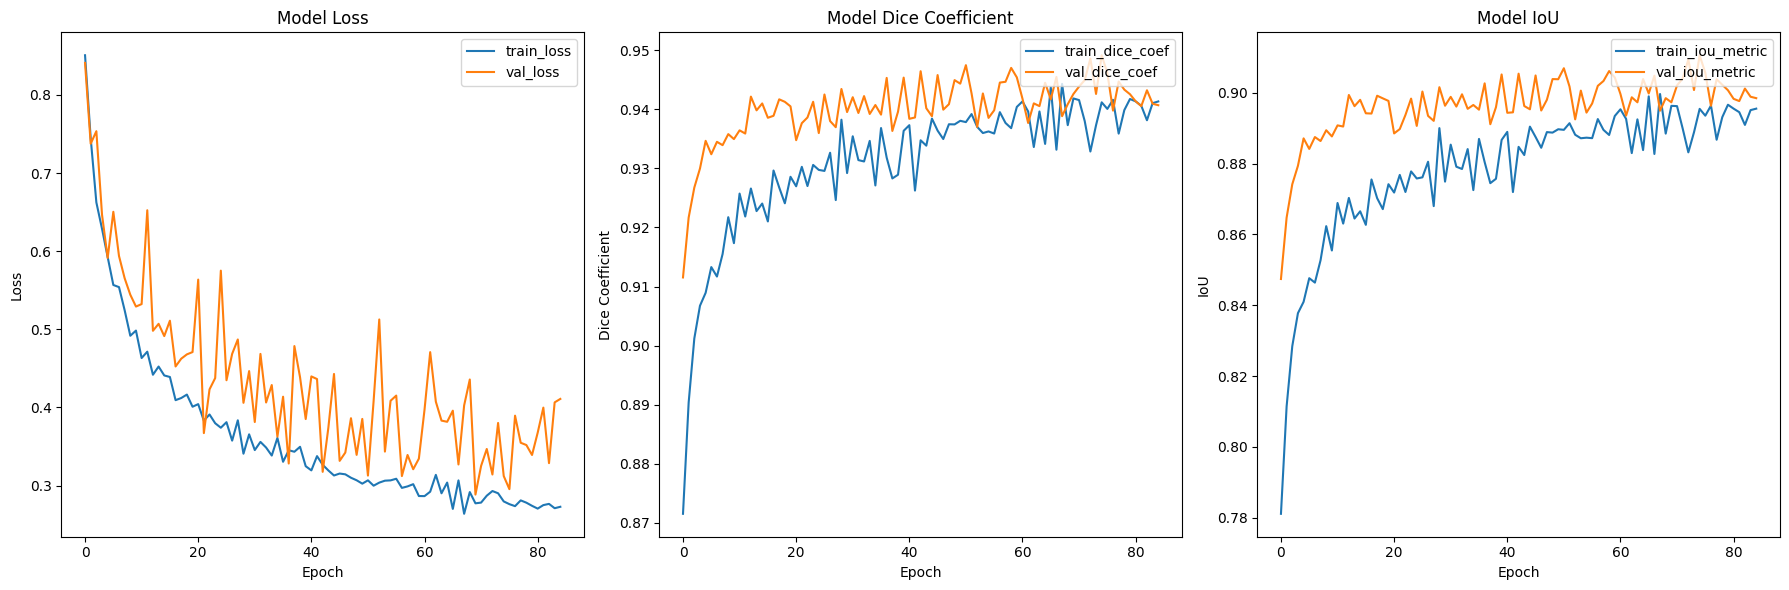

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation loss, dice coefficient, and IoU over epochs
def plot_training_history(history):
    # Summarize history for loss, dice coefficient, and IoU
    plt.figure(figsize=(18, 6))  # Increase figure size for 3 plots

    # Plot loss
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot Dice Coefficient
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second plot
    plt.plot(history.history['dice_coef_multiclass'], label='train_dice_coef')
    plt.plot(history.history['val_dice_coef_multiclass'], label='val_dice_coef')
    plt.title('Model Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot IoU
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third plot
    plt.plot(history.history['iou_multiclass'], label='train_iou_metric')
    plt.plot(history.history['val_iou_multiclass'], label='val_iou_metric')
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Call the function to plot
plot_training_history(history)